## Introduction

TEAMMATES: Akshat and Annie

The overall goal is to predict whether a payment by a company to a medical doctor or facility
was made as part of a research project or not.

### Imports

In [22]:
# data loading and manipulation
import pandas as pd
import numpy as np
import random
from category_encoders import TargetEncoder

# scikit learn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

%matplotlib inline

### Load data

The positive class corresponds to the payments that were made by a company to a doctor or facility that is part of the **research project**. The negative class on the other hand are the **general payments**. 

In the original data sets, the ratio of the positive class to the negative class is 1/20, making the positive class the minority class. 

Because the data sets are so large, we will subsample from the classes in order to maintain the same ratio. Thus we take 120K data points from Class 0, and 20K data points from Class 1. 

120K from the positive class turns out to be ~20% of the data, and 2M from the negative class is ~20% from the negative class. 

In [4]:
# Import 20% data randomly
p = 0.2
df0 = pd.read_csv('d0.csv', skiprows=lambda i: i>0 and random.random() > p)
df1 = pd.read_csv('d1.csv', skiprows=lambda i: i>0 and random.random() > p)

C:\Users\Akshat\Miniconda3\envs\aml_spring_19\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (4,7,9,11,14,16,17,21,22,23,24,35,36,37,40,41,42,43,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Akshat\Miniconda3\envs\aml_spring_19\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2,5,7,8,9,10,15,17,18,19,20,21,22,23,24,30,37,38,42,43,44,45,47,48,49,50,51,52,53,54,55,56,59,60,61,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,90,91,92,93,94,95,96,99,100,101,107,108,109,110,111,113,114,115,116,119,120,121,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,160,161,162,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df0.shape

(2132932, 75)

In [6]:
df1.shape

(120177, 176)

## Feature Intersection

There are 75 features present in the negative class, and 176 in the positive class. Our approach to combining the data sets for both the positive and the negative classs it to take an intersection of the features. 

In [7]:
notPrs = list(set(list(df1.columns)).difference(list(df0.columns)))
featureIntersection = list(set(list(df1.columns)).difference(notPrs))
print("There are {} features present in the intersection of the two dataframes.".format(len(featureIntersection)))

There are 64 features present in the intersection of the two dataframes.


In [8]:
df1 = df1[featureIntersection]
df0 = df0[featureIntersection]

Before we concatenate the two data sets, we add an indicator variable to each one specifying which class the data belongs to. We call this feature **target**, which is equal to 1 for the positive class and 0 for the negative class.

In [9]:
df1['Target'] = 1
df0['Target'] = 0

df = pd.concat([df1, df0], axis=0)
df.shape

(2253109, 65)

In [10]:
NAs = df.isna().mean().sort_values(ascending=False)

In [11]:
prelim = ['Recipient_Province', 
'Recipient_Postal_Code', 
'Recipient_Primary_Business_Street_Address_Line2',
'Teaching_Hospital_Name', 
'Teaching_Hospital_CCN',
'Teaching_Hospital_ID',
'Physician_Name_Suffix',       
'Program_Year', # because only 2017
'Physician_Profile_ID', # system generated unique identifier (IDs)
'Physician_Last_Name', 
'Physician_First_Name',
'Record_ID',
'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
'Physician_Profile_ID',
'Recipient_Zip_Code',
'Date_of_Payment',
'Physician_Middle_Name',       
]

In [12]:
dfTest = df.drop(columns=prelim, axis='columns')

In [13]:
dfTest.columns[dfTest.columns.str.contains('ID')]

Index([], dtype='object')

In [14]:
dfTest.shape

(2253109, 49)

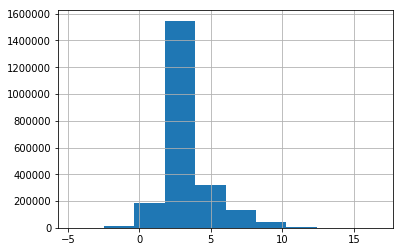

In [17]:
np.log(dfTest['Total_Amount_of_Payment_USDollars']).hist()


In [25]:
objVars = dfTest.select_dtypes(['object']).columns

dfTest.fillna('Missing', inplace=True)

target = dfTest['Target']
features = dfTest.drop(columns='Target')

# preprocess = ColumnTransformer(
#     ("dummies", OneHotEncoder(handle_unknown='ignore'), objVars)]
# )



In [19]:
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2253109 entries, 0 to 2132931
Data columns (total 49 columns):
Covered_or_Noncovered_Indicator_1                                   object
Recipient_City                                                      object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name       object
Change_Type                                                         object
Associated_Drug_or_Biological_NDC_4                                 object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4           object
Product_Category_or_Therapeutic_Area_3                              object
Associated_Drug_or_Biological_NDC_1                                 object
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1            object
Form_of_Payment_or_Transfer_of_Value                                object
Product_Category_or_Therapeutic_Area_4                              object
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name     

In [20]:
df.Product_Category_or_Therapeutic_Area_2.value_counts()

Diabetes                                                    79450
Cardiovascular & Metabolism                                 27381
RESPIRATORY                                                 23735
ENDOCRINOLOGY                                               21350
NEUROSCIENCE;PAIN                                           17697
NEUROSCIENCE                                                14042
DIABETES                                                    13815
Immunology                                                  12880
NEUROSCIENCE;TOBACCO DEPENDENCE                             11048
VACCINES                                                    10858
Oncology                                                    10610
Urology                                                     10475
GASTROENTEROLOGY                                            10009
CARDIOVASCULAR;METABOLIC DISEASE                             9170
CNS                                                          8671
WOMENS HEA

In [167]:
target = dfTest['Target']

colTransformer = ColumnTransformer()

In [28]:
enc = TargetEncoder(cols=['Product_Category_or_Therapeutic_Area_2']).fit(features, target)

In [31]:
enc.transform(features)

ValueError: cannot reindex from a duplicate axis

In [32]:
target.head()

0    1
1    1
2    1
3    1
4    1
Name: Target, dtype: int64